In [1]:
import torch, torch.nn as nn
import numpy as np, matplotlib.pyplot as plt
import itertools
from tqdm.auto import tqdm

def seq_mlp(init, mlp, fin, act):
    modules = [nn.Linear(init, mlp[0]), act]
    for i in range(len(mlp) - 1):
        modules.append(nn.Linear(mlp[i], mlp[i+1]))
        modules.append(act)

    modules.append(nn.Linear(mlp[-1], fin)) #self.spl for spline

    return modules

c:\Users\Hanse Kim\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [45]:
class EvalEig(nn.Module):
    def __init__(self, eval_para):
        super().__init__()   
        self.ln = eval_para['l_max']
        self.pw = eval_para['pw']
        self.batch_dim = eval_para['batch_dim']
        self.coeff_max = eval_para['coeff_max']

    def set_rdsc(self, rm, rn):
        self.rn = rn
        self.rm = rm
        self.r_dsc = torch.linspace(rm/rn, rm, rn)
        # batch x L x RxR
        self.l_dsc = torch.arange(0,self.ln+1, dtype = torch.int).view(1,-1,1,1)
    
    # set depends on range and distribution of values for coefficients
    def taylor_tr(self, para_ptl, ptl_form):
        coeffs_tr = torch.rand(self.batch_dim, self.pw+1)*para_ptl

        if ptl_form == "coulomb":
            coeffs_tr[:,0] = -1 + coeffs_tr[:,0]/10
            coeffs_tr[:,1:] = torch.tensor([0])
        elif ptl_form == "coulomb_like":
            coeffs_tr[:,0] = -1 + coeffs_tr[:,0]/10
            coeffs_tr[:,1:] = coeffs_tr[:,1:]*self.coeff_max
        elif ptl_form == "sho":
            coeffs_tr[:,0:] = torch.tensor([0])
            coeffs_tr[:,2] = 1
        elif ptl_form == "zero":
            coeffs_tr[:,0:] = torch.tensor([0])

        ptl_tr = coeffs_tr @ self.r_dsc_pw
        # batch x R
        return para_ptl*ptl_tr
    
    def fixed_tr(self, para_ptl, ptl_form):
        if ptl_form == "coulomb":
            #coeffs_tr = 1 + torch.rand(self.batch_dim, 1)/10
            coeffs_tr = torch.ones(self.batch_dim, 1)
            return -coeffs_tr*para_ptl/self.r_dsc.view(1,-1)
    
    def dsc_eigs(self, ptl):
        dsc_lap = (-2*torch.eye(self.rn) + torch.diag(torch.ones(self.rn-1),1) + torch.diag(torch.ones(self.rn-1),-1))/(2*(self.rm/self.rn)**2)
        dsc_lap = dsc_lap.view(1, 1, self.rn, self.rn)
        dsc_ptl = torch.diag_embed(ptl).view(self.batch_dim, 1, self.rn, self.rn)

        #dsc_lap = (-2*torch.eye(2*self.rn+1) + torch.diag(torch.ones(2*self.rn),1) + torch.diag(torch.ones(2*self.rn),-1))#/(2*(self.rm/self.rn)**2)
        #dsc_lap = dsc_lap.view(1, 1, 2*self.rn+1, 2*self.rn+1)
        #ptl_sym = torch.cat((torch.flip(ptl, dims = (1,)), torch.tensor([[1e-3]]), ptl), dim = 1)
        #dsc_ptl = torch.diag_embed(ptl_sym).view(self.batch_dim, 1, 2*self.rn+1, 2*self.rn+1)
        #r_dsc_sym = torch.cat((torch.flip(self.r_dsc, dims = (0,)), torch.tensor([1e-3]), self.r_dsc), dim = 0)

        #dsc_eff = self.l_dsc*(self.l_dsc+1)*torch.diag(1/r_dsc_sym**2).view(1, 1, 2*self.rn+1, 2*self.rn+1)
        dsc_eff = self.l_dsc*(self.l_dsc+1)*torch.diag(1/self.r_dsc**2).view(1, 1, self.rn, self.rn)
        dsc_hmt = -1*dsc_lap + dsc_ptl + 1*dsc_eff # fix coefficient hba^2/2m = 1

        evl, _ = torch.linalg.eigh(dsc_hmt)

        return evl
    
    def evl_cutoff(self, evl):
        cutoff = evl.shape[2]
        for i in range(evl.shape[1]):
            cutoff = min(cutoff, evl[:,i][evl[:,i]<0].shape[0])
        cutoff = max(cutoff - 5, 5)

        self.cutoff = cutoff
        return cutoff
    
    def evl_scl(self, evl):
        evl_scl = (evl/evl[:,:,0].view(evl.shape[0],evl.shape[1],1).expand(-1, evl.shape[1], evl.shape[2]))[:,:,1:]
        return evl_scl
    
    def forward(self, rm, rn, para_ptl, ptl_form):
        self.set_rdsc(rm, rn)
        ptl_tr = self.fixed_tr(para_ptl, ptl_form)
        evl_tr = self.dsc_eigs(ptl_tr) # eval true eigenvalues
        evl_tr_cut = evl_tr[:,:,:self.evl_cutoff(evl_tr)]
        evl_tr_scl = self.evl_scl(evl_tr_cut)

        return ptl_tr, evl_tr_scl

class InvEig(EvalEig):
    def __init__(self, eval_para, model_para):
        super().__init__(eval_para)

    def set_rdsc(self, rm, rn, cutoff):
        self.rn = rn
        self.rm = rm
        self.r_dsc = torch.linspace(rm/rn, rm, rn)
        # batch x L x RxR
        self.l_dsc = torch.arange(0,self.ln+1, dtype = torch.int).view(1,-1,1,1)
        self.cutoff_md = cutoff

        # initialise model
        #self.ptl = nn.Parameter(torch.rand(self.batch_dim, self.rn-1)) # random parameters
        #modules = seq_mlp(init = self.rn, mlp = model_para['mlp'], fin = self.rn-1, act = nn.ReLU())
        modules = seq_mlp(init = 1, mlp = model_para['mlp'], fin = 1, act = nn.ReLU())
        self.mlp = nn.Sequential(*modules)
        self.expn = nn.Parameter(torch.tensor([1.]))

    def forward(self, energy):
        # obtain potential via model
        #ptl_md = torch.cat((torch.tensor([-self.rn/self.rm]).view(1,-1).expand(self.batch_dim,-1),self.ptl),dim=1) # random parameters
        #ptl_md = torch.cat((torch.tensor([-self.rn/self.rm]).view(1,-1).expand(self.batch_dim,-1),self.mlp(self.r_dsc).view(1,-1).expand(self.batch_dim,-1)),dim=1) # random parameters
        #ptl_md = self.mlp(self.r_dsc.view(-1,1)).view(1,-1).expand(self.batch_dim,-1)*(1/self.r_dsc**self.expn)
        ptl_md = self.mlp(self.r_dsc.view(-1,1)).view(1,-1).expand(self.batch_dim,-1)*(1/self.r_dsc)

        evl_md = self.dsc_eigs(ptl_md)
        evl_md_cut = evl_md[:,:,:self.cutoff_md]
        evl_md_scl = self.evl_scl(evl_md_cut)

        return ptl_md, evl_md_scl


In [50]:
eval_para = {
        # evaluation model
        #'r_infty' : 1, # keep as <1 for numerical stability of taylor series
        #'rn' : 1000, # computation time vs accuracy; maintain delta r ~ 0
        'l_max' : 2, # maximum l_max to evaluate radial schrodinger upto
        
        # potential specifics
        #'para_1' : 1e-3, # scales energy; ensure r_infty * para_1 < 1e-3 (roughly V(r_infty) << 1)

        # training data specifics
        #'ptl_form' : 'sho', # coulomb, coulomb_like
        'pw' : 20, # consider 1/r and up to r^n
        'coeff_max' : 100,

        # model specifics
        'precision' : 64, # 32 or 64 bit
        'batch_dim' : 1,
        }

model_para = {
        # model
        'mlp' : [100, 100],

        # training
        'epoch' : 100,
        'lr' : 1e-2,

        # loss regularisation
        'reg1' : 1e-1, # smoothness
        
        }

eval = EvalEig(eval_para)

In [51]:
#eval_grid = [[800], \
#    [10000], \
#        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]] # rm, rn, para_1
#for midx in itertools.product(*eval_grid):
#for midx in zip(*eval_grid):
    #eval.set_rdsc(midx[0], midx[1])
    #ptl_tr = eval.fixed_tr(midx[2], "coulomb")
    #evl_scl_tr = eval.dsc_eigs(ptl_tr)
    #evl_tr = evl_scl_tr[:,:,:eval.evl_cutoff(evl_scl_tr)]
#    ptl_tr, evl_tr = eval(midx[0], midx[1], midx[2], "coulomb")
#    factor = torch.mean(1/evl_tr, dim = 0)
#    print(factor[0])
#    print(midx, nn.L1Loss()(factor[0],torch.arange(1,factor.shape[1]+1)**2), evl_tr[0,0,0])

In [52]:
ptl_tr, evl_tr = eval(800, 1000, 1, "coulomb")

print(1/evl_tr)

tensor([[[  3.6429,   8.0305,  14.1701,  22.0633,  31.7103,  43.1106,  56.2654,
           71.1736,  87.8369, 106.2513, 126.4220, 148.3455, 172.0238, 197.4539,
          224.6383, 253.5773],
         [  1.9309,   3.1663,   4.7068,   6.5528,   8.7043,  11.1611,  13.9238,
           16.9920,  20.3655,  24.0447,  28.0293,  32.3202,  36.9165,  41.8185,
           47.0262,  52.5703],
         [  1.5620,   2.2487,   3.0603,   3.9967,   5.0582,   6.2446,   7.5561,
            8.9925,  10.5542,  12.2405,  14.0522,  15.9886,  18.0503,  20.2384,
           22.5957,  25.4611]]])


In [53]:
model = InvEig(eval_para, model_para)
model.set_rdsc(800, 1000, eval.cutoff)

optimiser = torch.optim.Adam(model.parameters(), lr = model_para['lr'])
epochs = model_para['epoch']
pbar = tqdm(range(epochs), desc='Progress', total=epochs, leave = True, position=0, colour='blue')
loss_list = [[],[]]

for e in range(epochs):
    #ptl_md, evl_md = model(hp['true'])
    #with torch.autograd.detect_anomaly():
    
    ptl_md, evl_md = model(evl_tr)
    if e == 0:
        ptl_init = ptl_md

    loss0 = nn.L1Loss()(evl_tr, evl_md)
    #loss = nn.L1Loss()(ptl_md, ptl_tr)

    loss1 = torch.sum((ptl_md[:,1:]-ptl_md[:,:-1])**2)

    loss_list[0].append(loss0.item())
    loss_list[1].append(loss1.item())

    loss = loss0# + model_para['reg1']*loss1

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    pbar.update()

Progress: 100%|██████████| 100/100 [00:18<00:00,  5.72it/s]

In [54]:
torch.save(model.state_dict(), f"{eval_para['batch_dim']}.pth")
#model.load_state_dict(torch.load('.pth'))

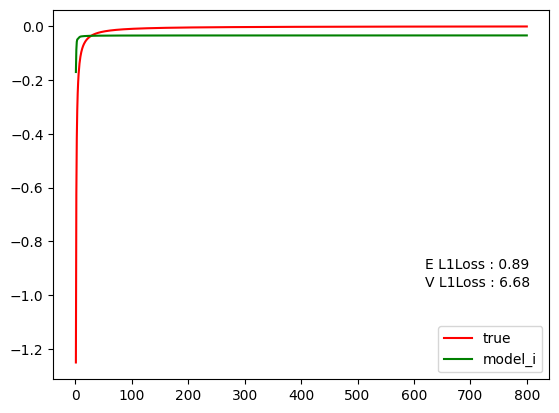

In [57]:
plt.figure()
i = 0
plt.plot(eval.r_dsc, ptl_tr[i], label='true', color = 'red')
plt.plot(eval.r_dsc, ptl_init[i].squeeze(0).detach(), label='model_i', color = 'green')
#plt.plot(eval.r_dsc, ptl_md[i].squeeze(0).detach(), label='model', color = 'blue')
plt.legend()
plt.annotate(f"E L1Loss : {loss:.2f}", xy = (0.75, 0.3), xycoords="axes fraction")
plt.annotate(f"V L1Loss : {nn.L1Loss()(ptl_tr[i], ptl_md[i]).item():.2f}", xy = (0.75, 0.25), xycoords="axes fraction")
plt.savefig(f"{eval_para['batch_dim']}_{eval_para['pw']}_{i}ptl.png")

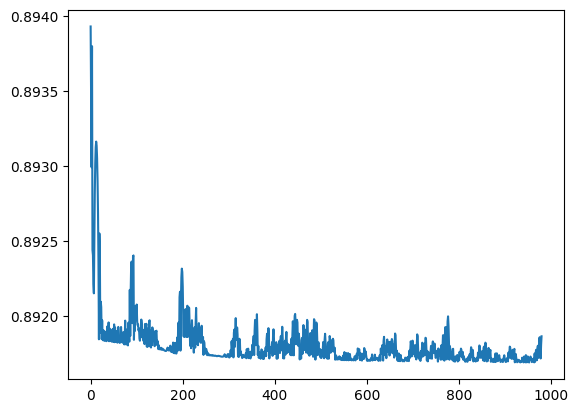

In [29]:
plt.figure()
j = 20
plt.plot(range(epochs-j), loss_list[0][j:])
#plt.plot(range(epochs-j), loss_list[1][j:])
plt.savefig(f"{eval_para['batch_dim']}_{eval_para['pw']}_loss.png")